     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
!pip install huggingface_hub unsloth datasets trl transformers
from unsloth import FastLanguageModel
from datasets import load_dataset
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from trl import SFTTrainer
from unsloth.chat_templates import get_chat_template, train_on_responses_only


max_seq_length = 2048
dtype = None
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)


model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
)


dataset = load_dataset("codeparrot/xlcost-text-to-code", "Python-program-level", split="train")


def formatting_prompts_func(examples):
    texts = []
    for text, code in zip(examples["text"], examples["code"]):
        # Define the prompt format you want the model to learn
        prompt = f"<|begin_of_text|><|start_header_id|>text<|end_header_id|>\n{text}\n<|start_header_id|>code<|end_header_id|>\n{code}<|eot_id|>"
        texts.append(prompt)
    return {"text": texts}


dataset = dataset.map(formatting_prompts_func, batched=True)


trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer),
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,  # Adjust based on your training needs
        learning_rate=2e-4,
        fp16=True,  # Enable fp16 if supported
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
    ),
)


trainer = train_on_responses_only(
    trainer,
    instruction_part="<|start_header_id|>text<|end_header_id|>\n\n",
    response_part="<|start_header_id|>code<|end_header_id|>\n\n",
)


trainer_stats = trainer.train()


model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")





==((====))==  Unsloth 2024.11.11: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,263 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss
1,0.927600
2,1.003000
3,1.046300
4,0.959200
5,0.990300
6,0.923900
7,0.776200
8,0.690500
9,0.613000
10,0.568700


('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [11]:
model = FastLanguageModel.for_inference(model)

messages = [
    {"role": "user", "content": "Maximum Prefix Sum possible by merging two given arrays"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

outputs = model.generate(input_ids=inputs, max_new_tokens=64, use_cache=True, temperature=1.5, min_p=0.1)
print(tokenizer.batch_decode(outputs))

['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 28 Nov 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nMaximum Prefix Sum possible by merging two given arrays<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\ndef maximumPrefixSum ( arr1, arr2 ) : NEW_LINE INDENT sum = 0 NEW_LINE for i in range ( 0, len ( arr1 ) ) : NEW_LINE INDENT sum += ( arr1 [ i ] * ( i + 1 ) ) NEW_LINE DEDENT return (']


{'train_runtime': 331.4667, 'train_samples_per_second': 1.448, 'train_steps_per_second': 0.181, 'total_flos': 3867404843409408.0, 'train_loss': 0.4899890502293905, 'epoch': 0.05181347150259067}


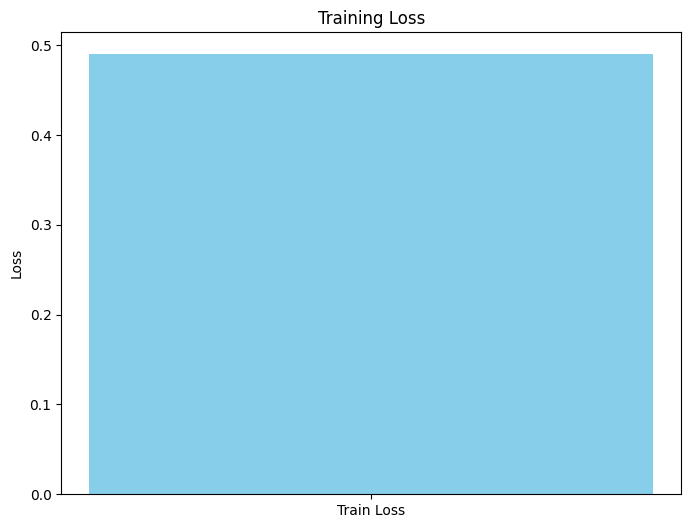

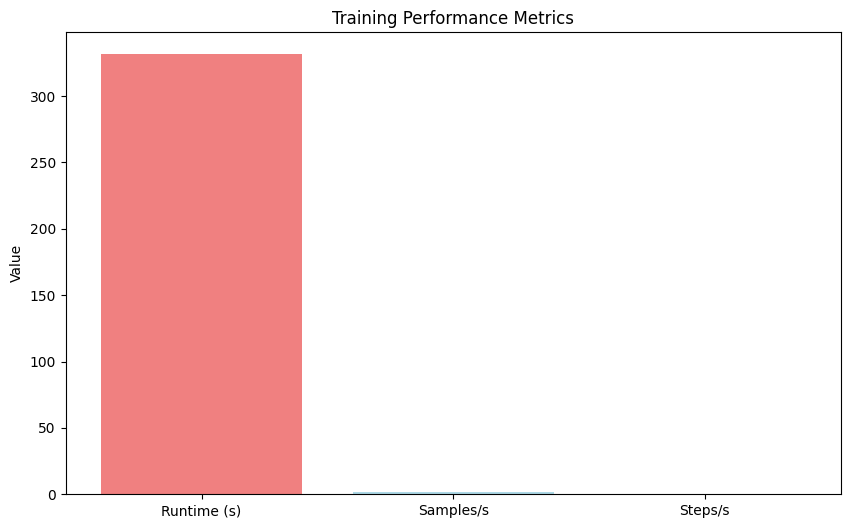

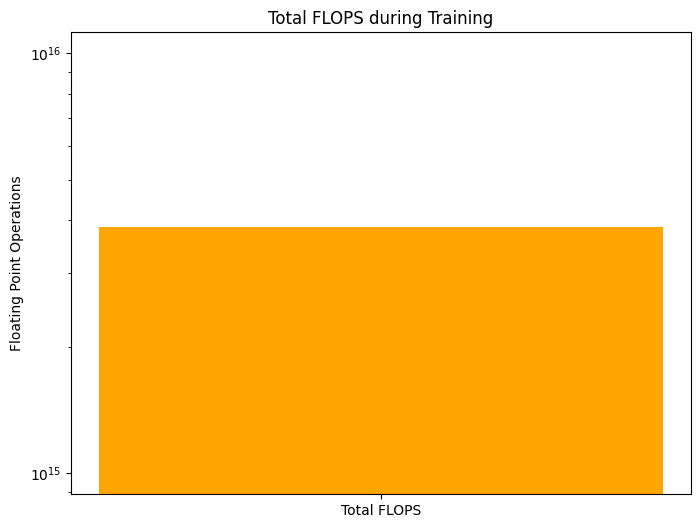

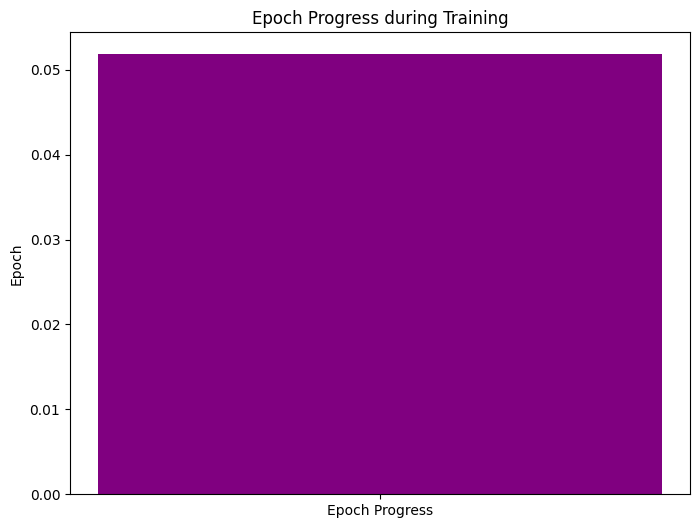

In [17]:
import matplotlib.pyplot as plt

# Extract metrics from training stats
metrics = trainer_stats.metrics
print(metrics)

plt.figure(figsize=(8, 6))
plt.bar(['Train Loss'], [metrics['train_loss']], color='skyblue')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot runtime and performance metrics
plt.figure(figsize=(10, 6))
x = ['Runtime (s)', 'Samples/s', 'Steps/s']
y = [metrics['train_runtime'], metrics['train_samples_per_second'], metrics['train_steps_per_second']]
plt.bar(x, y, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.ylabel('Value')
plt.title('Training Performance Metrics')
plt.show()

# FLOPS plot (optional)
plt.figure(figsize=(8, 6))
plt.bar(['Total FLOPS'], [metrics['total_flos']], color='orange')
plt.ylabel('Floating Point Operations')
plt.title('Total FLOPS during Training')
plt.yscale('log')  # Use log scale for large numbers
plt.show()

# Epoch progress (optional)
plt.figure(figsize=(8, 6))
plt.bar(['Epoch Progress'], [metrics['epoch']], color='purple')
plt.ylabel('Epoch')
plt.title('Epoch Progress during Training')
plt.show()